In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
import seaborn as sns

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [8]:
d = extract.get_data()
d = extract.clean_data(d)

In [9]:
s0 = pd.read_csv("price_change_data.csv", usecols = ['d_index', 'tradetype',
		'state', 'coupon', 'maturity', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'dprice', 'holdtime'])

In [10]:
d_index = s0.pop('d_index')
s_state_features = extract.build_state_features(s0, num_states = 20)
s_other_features = extract.build_other_text_features(s0)
s = pd.concat([s0.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), s_state_features, s_other_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < 7 days

In [11]:
dprice = s.pop('dprice')

## Bin First, Then Classify

### Binarize the dprice variable: 0 means loss, 1 means a gain:

In [31]:
dprice_binary = dprice.apply(lambda x: x > 0).astype(np.int)

In [32]:
s_train, s_test, dp_train, dp_test = train_test_split(s, dprice_binary, test_size=0.20, random_state=203)

### Set the various classifiers to try:

In [33]:
names = ["Decision Tree", "Random Forest", "Naive Bayes"]
classifiers = [DecisionTreeClassifier(max_depth=25),
		RandomForestClassifier(max_depth=25, n_estimators=100),
		GaussianNB()]

Decision Tree: number correct predictions/total samples = 0.902369668246


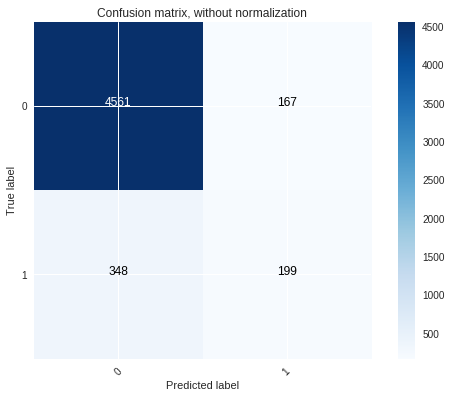

Random Forest: number correct predictions/total samples = 0.912606635071


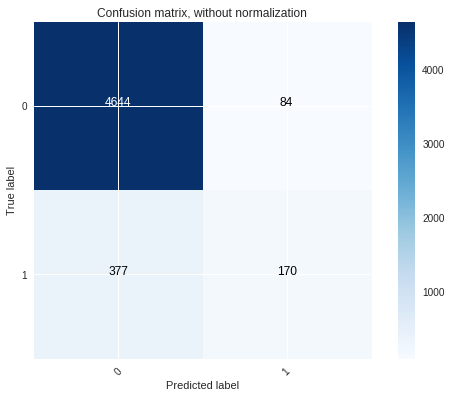

Naive Bayes: number correct predictions/total samples = 0.746161137441


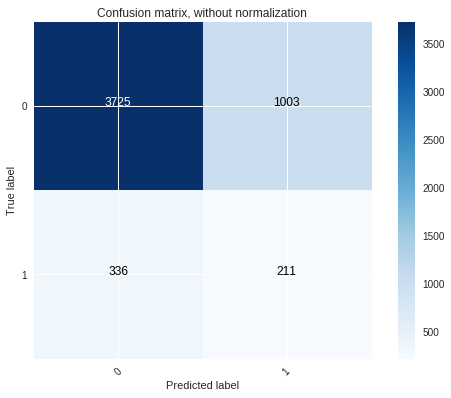

In [34]:
for name, clf in zip(names, classifiers):
		clf = clf.fit(s_train, dp_train)
		dp_pred = clf.predict(s_test)
        	score = clf.score(s_test, dp_test)
		print(name + ": number correct predictions/total samples = {}".format(score))
		# Compute confusion matrix
		cnf_matrix = confusion_matrix(dp_test, dp_pred)
		plt.figure()
		visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
		plt.show()

### Now we can try to predict more precisely how much of a gain or loss one can potentially get, using more bins:

In [35]:
bins = [-3, -1, 0, 1, 3]
dprice_binned = np.digitize(dprice.values, bins)

In [36]:
dprice_binned[:5]

array([2, 3, 3, 2, 3])

In [37]:
dprice[:5].values

array([-0.762,  0.376,  0.473, -0.665,  0.473])

In [38]:
s_train, s_test, dp_train, dp_test = train_test_split(s, dprice_binned, test_size=0.20, random_state=53)

Decision Tree: number correct predictions/total samples = 0.637725118483


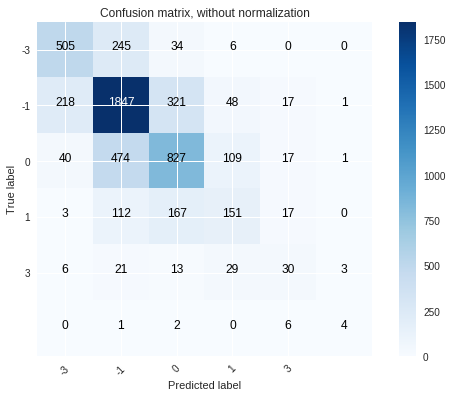

Random Forest: number correct predictions/total samples = 0.652511848341


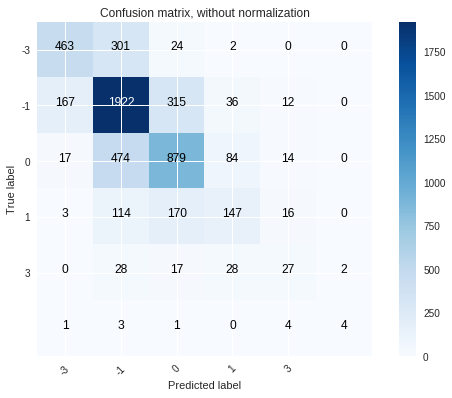

Naive Bayes: number correct predictions/total samples = 0.349004739336


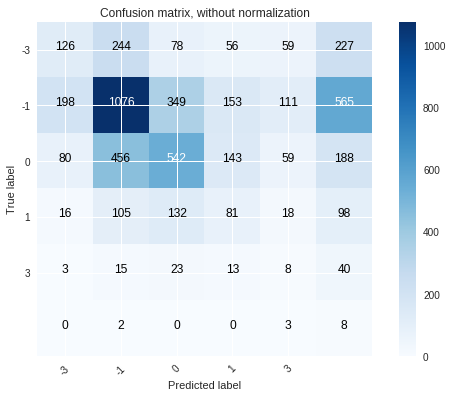

In [39]:
for name, clf in zip(names, classifiers):
		clf = clf.fit(s_train, dp_train)
		dp_pred = clf.predict(s_test)
		score = clf.score(s_test, dp_test)
		print(name + ": number correct predictions/total samples = {}".format(score))
		# Compute confusion matrix
		cnf_matrix = confusion_matrix(dp_test, dp_pred)
		plt.figure()
		visualize.plot_confusion_matrix(cnf_matrix, classes=bins, title='Confusion matrix, without normalization')
		plt.show()

### Let us try to see more closely which bonds are yielding positive returns (bin index 3-5 represent positive gains):

In [40]:
clf = RandomForestClassifier(max_depth=25, n_estimators=100)
clf = clf.fit(s_train, dp_train)
dp_pred = clf.predict(s)

In [52]:
print dp_pred[:20]

[2 2 3 2 2 3 2 2 3 1 1 1 0 0 0 1 1 1 1 2]


In [51]:
print dprice_binned[:20]

[2 3 3 2 3 3 2 2 4 1 1 1 0 0 0 1 1 1 1 1]


In [50]:
print dprice[:20].values

[ -7.62000000e-01   3.76000000e-01   4.73000000e-01  -6.65000000e-01
   4.73000000e-01   5.70000000e-01  -3.00000000e-03  -1.50000000e-02
   1.12600000e+00  -1.96700000e+00  -1.81700000e+00  -2.20400000e+00
  -3.22800000e+00  -3.22800000e+00  -3.30000000e+00  -2.75400000e+00
  -2.07000000e+00  -1.93100000e+00  -2.22400000e+00  -1.52600000e+00]


In [53]:
I = s[dprice_binned >= 3].index #respresents index set of rows from s that yields a positive return

In [56]:
dprice[I][:10]

1      0.376
2      0.473
10     0.473
11     0.570
26     1.126
129    0.452
130    0.332
222    0.582
279    3.817
280    2.879
Name: dprice, dtype: float64

In [57]:
good_d_rows = list(set(d_index[I].values)) #get unique row indices from d where an initial sale lead to positive gains

In [58]:
good_d = d.loc[good_d_rows, :]
good_d[:10]

,tradeid,cusip,amount,price,yield,tradedate,tradetype,name,state,coupon,maturity,issuesize,issuetype,issuesource,bidcount,rtg
0,317.0,45471AKG6,5000.0,99.507,4.037,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
1,318.0,45471AKG6,30000.0,99.410,4.045,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
24578,63754.0,914460LE8,40000.0,95.230,4.090,21.0,Sale_to_Customer,univ of mn-b-txbl,Minnesota,3.75,7642.0,2325000.0,REVENUE BONDS,COLLEGE & UNIV. REV.,3.0,2
16388,42492.0,64972GFA7,45000.0,113.550,2.946,16.0,Sale_to_Customer,nyc muni wtr-dd-ref,New York,5.00,7046.0,174030000.0,REVENUE BONDS,WATER REVENUE,NaN,2
14,823.0,575579HB6,10000.0,118.093,2.350,0.0,Sale_to_Customer,ma bay trn,Massachusetts,5.00,2679.0,93065000.0,REVENUE BONDS,SALES TAX REVENUE,NaN,2
27,1583.0,57583R5N1,250000.0,112.250,1.639,0.0,Sale_to_Customer,ma dev-b1-harvard unv,Massachusetts,5.00,8629.0,260675000.0,REVENUE BONDS,COLLEGE & UNIV. REV.,NaN,1
28,1584.0,57583R5N1,250000.0,112.250,1.639,0.0,Sale_to_Customer,ma dev-b1-harvard unv,Massachusetts,5.00,8629.0,260675000.0,REVENUE BONDS,COLLEGE & UNIV. REV.,NaN,1
29,1585.0,57583R5N1,200000.0,112.209,1.650,0.0,Sale_to_Customer,ma dev-b1-harvard unv,Massachusetts,5.00,8629.0,260675000.0,REVENUE BONDS,COLLEGE & UNIV. REV.,NaN,1
30,1586.0,57583R5N1,400000.0,112.000,1.703,0.0,Sale_to_Customer,ma dev-b1-harvard unv,Massachusetts,5.00,8629.0,260675000.0,REVENUE BONDS,COLLEGE & UNIV. REV.,NaN,1
24613,64639.0,927676MX1,15000.0,100.000,4.897,21.0,Sale_to_Customer,vi fin gross rcpts ln,Virgin Islands,5.00,3501.0,19530000.0,REVENUE BONDS,SALES TAX REVENUE,NaN,4


In [59]:
good_d.name.value_counts()[:20]

buckeye tob asset-a-2    52
il st txb-pension        38
california st            32
ca stwd cmntys-a-ref     29
fl hurricane-ser a       24
ca txb-var purp          21
ca dept wtr resources    20
pennsylvania-1st ser     18
ca st                    13
ca st univ-a             13
nj transprtn trust-aa    12
liberty dev goldman      12
ysleta isd-bldg          12
salt verde fnl corp      11
ca econ-a-preref-ref     10
california st-ref        10
tob settlement ser 1a    10
ny dorm auth-a            9
univ of ct-a              9
miami-dade co wtr-ref     9
Name: name, dtype: int64

In [61]:
s.loc[I,:].holdtime.value_counts()

1.0    620
6.0    568
3.0    458
5.0    446
4.0    404
2.0    393
Name: holdtime, dtype: int64

In [62]:
I_pred = s[dp_pred >= 3].index #respresents predicted index set of rows from s1 that yields a positive return

In [65]:
dprice[I_pred][50:60]

1932    0.568
1939    0.375
1945    0.913
1972    0.684
3930   -0.925
3931    1.498
4044    1.430
4045    1.347
4055    1.290
4056    1.207
Name: dprice, dtype: float64

In [66]:
good_d_rows_pred = list(set(d_index[I_pred].values)) #get unique row indices from d where an initial sale is predicted to lead to positive gains

In [68]:
good_d_pred = d.loc[good_d_rows_pred, :]
good_d_pred[:10]

,tradeid,cusip,amount,price,yield,tradedate,tradetype,name,state,coupon,maturity,issuesize,issuetype,issuesource,bidcount,rtg
0,317.0,45471AKG6,5000.0,99.507,4.037,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
1,318.0,45471AKG6,30000.0,99.410,4.045,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
6146,57118.0,794665FP9,15000.0,118.924,2.320,6.0,Sale_to_Customer,sales tax asset-a,New York,5.00,3880.0,129315000.0,REVENUE BONDS,SALES TAX REVENUE,NaN,1
8047,20030.0,011415PT7,15000.0,103.654,1.600,8.0,Sale_to_Customer,alamon clg-ref,Texas,5.00,351.0,4415000.0,GENERAL OBLIGATION LTD,AD VALOREM PROPERTY TAX,NaN,1
28677,53852.0,74529JAC9,420000.0,67.625,9.771,23.0,Sale_to_Customer,pr s/tax-ser b,Puerto Rico,6.05,7093.0,575000000.0,REVENUE BONDS,SALES TAX REVENUE,NaN,19
7169,27286.0,13066YQC6,50000.0,104.906,1.200,7.0,Sale_to_Customer,ca wtr,California,5.00,426.0,181785000.0,REVENUE BONDS,ELEC. PWR. & LT. REVS.,NaN,3
16708,33668.0,59334DBV5,25000.0,102.587,1.200,16.0,Sale_to_Customer,miami etc w/s-ref,Florida,5.00,214.0,3215000.0,REVENUE BONDS,WATER REVENUE,NaN,4
25260,53926.0,74529JAG0,75000.0,23.155,6.060,22.0,Sale_to_Customer,pr s/tax-cabs-a,Puerto Rico,0.00,8919.0,114697901.1,REVENUE BONDS,SALES TAX REVENUE,6.0,4
2061,29727.0,429335GZ9,135000.0,116.117,2.880,1.0,Sale_to_Customer,hidalgo drain dt #1,Texas,5.00,3836.0,4725000.0,GENERAL OBLIGATION UNLTD,AD VALOREM PROPERTY TAX,NaN,3
10161,4398.0,13937KGV2,100000.0,98.248,3.630,10.0,Sale_to_Customer,cape coral-ref,Florida,3.50,6788.0,2720000.0,REVENUE BONDS,APPROPRIATIONS,NaN,4


In [69]:
d.issuetype.value_counts()

REVENUE BONDS                23546
GENERAL OBLIGATION UNLTD      9066
GENERAL OBLIGATION LTD        1604
CERTIFICATE PARTICIPATION      798
TAX ALLOCATION                 306
SPECIAL ASSESSMENT              85
SPECIAL TAX                     51
Name: issuetype, dtype: int64

In [70]:
good_d_pred.issuetype.value_counts()

REVENUE BONDS                763
GENERAL OBLIGATION UNLTD     288
GENERAL OBLIGATION LTD        51
CERTIFICATE PARTICIPATION     25
TAX ALLOCATION                 5
SPECIAL TAX                    2
SPECIAL ASSESSMENT             1
Name: issuetype, dtype: int64

In [72]:
good_d.issuetype.value_counts()

REVENUE BONDS                1120
GENERAL OBLIGATION UNLTD      376
GENERAL OBLIGATION LTD         56
CERTIFICATE PARTICIPATION      32
TAX ALLOCATION                  5
SPECIAL TAX                     2
SPECIAL ASSESSMENT              1
Name: issuetype, dtype: int64

In [73]:
d.state.value_counts()[:20]

California           5973
New York             4172
Texas                2445
Illinois             2300
New Jersey           2186
Florida              2129
Pennsylvania         1722
Puerto Rico          1698
Massachusetts        1377
Ohio                 1076
Washington            824
Arizona               571
South Carolina        569
Connecticut           561
Michigan              535
Maryland              483
Louisiana             435
Georgia               406
Virginia              398
Dist. of Columbia     361
Name: state, dtype: int64

In [74]:
good_d.state.value_counts()[:20]

California        340
New York          206
Florida           108
Texas              99
Pennsylvania       85
Illinois           83
Ohio               78
Massachusetts      76
New Jersey         72
Puerto Rico        49
Arizona            39
Washington         36
Connecticut        28
Maryland           26
South Carolina     22
Michigan           19
Georgia            17
Wisconsin          14
Virgin Islands     14
Kentucky           14
Name: state, dtype: int64